# Pre-Processing and Training Data


From the EDA we were able to determined what seemed like the best opening for white. We were able to determine that Queen's Gambit Accepted seems to be one of the most popular and successful openings for white. 

Next we want to determine what predicts the outcome of games that we deem a "fair fight". Is it elo difference, time, moving first (white), increment, or opening choice. 
In this notebook, we will start to build machine learning models. 


In [1]:
import pandas as pd
import numpy as np

import re
from tqdm import tqdm
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
import datetime



In [2]:
# Load the dataset into a pandas dataframe
df = pd.read_csv('df_EDA_result.csv', index_col=[0])

In [3]:
df = df.reset_index(drop=True)

While we would love to look at everything, we are unfotunetly running into memory issues again. We will have to remove some data. We will be removing the following data to make it easier for the computer to handle. 
- Elo difference absolute - While this data is important to see trends in wins elo difference give us a fuller picture. 
- White / Black first move - This data is theoratically covered by opening. 
- Game URL - This shouldn't inflence anything. 
- Termination - This tells us how the game finished not who won. 

Furthermore, we will be:
- Changing Time Control: Increment to just a 1 or a 0 (yes or no).
- Combining Opening and Opening Variation and then looking at the most popular of those. 

In [4]:
pd.set_option('display.max_rows', df.shape[0]+1)
df['Opening Variation'].value_counts(normalize=True).cumsum().head(192)

 Mieses-Kotroc Variation                                    0.031225
 Mason Variation                                            0.060088
 Exchange Variation                                         0.085342
 Classical Variation                                        0.106648
 Normal Variation                                           0.126906
 Knight Variation                                           0.146203
 Bowdler Attack                                             0.162914
 Modern Variation                                           0.178800
 Old Sicilian                                               0.194536
 Italian Variation                                          0.209370
 Chigorin Variation                                         0.224101
 Advance Variation                                          0.236450
 Leonardis Variation                                        0.247965
 Zukertort Variation                                        0.259349
 Main Line                        

In [5]:
mask = df['Opening Variation'].isin(df['Opening Variation'].value_counts(normalize=True).cumsum().head(192).index)
df = df[mask]

In [6]:
# dropping columns
df.drop(columns=['Elo Difference Absolute', 'White First Move', 'Black First Move', 'Game URL', 'Termination'], inplace=True)

In [7]:
# changing Time Control: Increment to just 1 or 0. 
df['Time Control: Increment'] = df['Time Control: Increment'].apply(lambda x: 0 if x == 0 else 1)

In [8]:
df["Opening"] = df.apply(lambda x: str(x["Opening"]) + ":" + str(x["Opening Variation"]), axis=1)
df.drop("Opening Variation", axis=1, inplace=True)
df['Opening'] = df['Opening'].str.replace(':nan', '')

In [9]:
print(df.dtypes)

Opening                     object
White Elo                    int64
Black Elo                    int64
Elo Difference               int64
White Won                  float64
Time Control                 int64
Time Control: Increment      int64
dtype: object


In [10]:
# converting to int16 to save memory.
cols_to_convert = ["White Elo", "Black Elo", "Elo Difference"]
df[cols_to_convert] = df[cols_to_convert].astype('int64')
# converting to category to save memory.
cols_to_convert2 = ["Time Control: Increment", "Time Control", "Opening"]
df[cols_to_convert2] = df[cols_to_convert2].astype('category')
# converting to float64.
df["White Won"] = df["White Won"].astype('float64')

In [11]:
# df["White Result"] = df["White Won"].str.replace(re.escape('0.5'), 'Drawn') \
#                                                 .str.replace(re.escape('1.0'), 'Won') \
#                                                 .str.replace(re.escape('0.0'), 'Lost') 

In [12]:
# # dropping columns
# df.drop(columns=['White Won'], inplace=True)

In [13]:
print(df.dtypes)

Opening                    category
White Elo                     int64
Black Elo                     int64
Elo Difference                int64
White Won                   float64
Time Control               category
Time Control: Increment    category
dtype: object


In [14]:
df.head()

,Opening,White Elo,Black Elo,Elo Difference,White Won,Time Control,Time Control: Increment
0,Sicilian Defense: Bowdler Attack,1429,1460,-31,1.0,300,1
1,King's Pawn Game: Leonardis Variation,1687,1647,40,1.0,300,1
3,Queen's Gambit Declined: Marshall Defense,1101,1086,15,0.0,300,1
4,Sicilian Defense: Smith-Morra Gambit,1362,1408,-46,0.0,300,1
6,Queen's Gambit Declined: Baltic Defense,1175,1228,-53,0.0,300,1


In [15]:
df.shape

(18877764, 7)

# Train/Test Split


In [16]:
# What partition sizes would you have with a 70/30 train/test split?
len(df) * .7, len(df) * .3, 

(13214434.799999999, 5663329.2)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='White Won'), 
                                                    df['White Won'], test_size=0.999, 
                                                    random_state=47)

In [18]:
X_train.shape, X_test.shape

((18877, 6), (18858887, 6))

In [19]:
y_train.shape, y_test.shape

((18877,), (18858887,))

In [20]:
#Save the 'Opening', 'Time Control', 'Time Control: Increment' columns from the train/test data into names_train and names_test
#Then drop those columns from `X_train` and `X_test`. Use 'inplace=True'
names_list = ['Opening', 'Time Control', 'Time Control: Increment']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((18877, 3), (18858887, 3))

In [21]:
X_train.dtypes

White Elo         int64
Black Elo         int64
Elo Difference    int64
dtype: object

In [22]:
X_test.dtypes


White Elo         int64
Black Elo         int64
Elo Difference    int64
dtype: object

# Initial Not-Even-A-Model

A good place to start is to see how good the mean is as a predictor.

In [23]:
df['White Won'].unique()

array([1. , 0. , 0.5])

In [24]:
train_mean = y_train.mean()
train_mean

0.5220903745298512

In [25]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[0.52209037]])

# Metrics


R-squared, or coefficient of determination


In [26]:
def r_squared(y, ypred):
    """R-squared score.
    
    Calculate the R-squared, or coefficient of determination, of the input.
    
    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    ybar = np.sum(y) / len(y) #yes, we could use np.mean(y)
    sum_sq_tot = np.sum((y - ybar)**2) #total sum of squares error
    sum_sq_res = np.sum((y - ypred)**2) #residual sum of squares error
    R2 = 1.0 - sum_sq_res / sum_sq_tot
    return R2

In [27]:
y_tr_pred_ = train_mean * np.ones(len(y_train))
y_tr_pred_[:5]

array([0.52209037, 0.52209037, 0.52209037, 0.52209037, 0.52209037])

In [28]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([0.52209037, 0.52209037, 0.52209037, 0.52209037, 0.52209037])

In [29]:
r_squared(y_train, y_tr_pred)

0.0

In [30]:
y_te_pred = train_mean * np.ones(len(y_test))
r_squared(y_test, y_te_pred)

-4.9539575256440926e-05

Mean Absolute Error

In [31]:
def mae(y, ypred):
    """Mean absolute error.
    
    Calculate the mean absolute error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    abs_error = np.abs(y - ypred)
    mae = np.mean(abs_error)
    return mae

In [32]:
mae(y_train, y_tr_pred)

0.4768716271312038

In [33]:
mae(y_test, y_te_pred)


0.47876191617923775

Mean Squared Error

In [34]:
def mse(y, ypred):
    """Mean square error.
    
    Calculate the mean square error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    sq_error = (y - ypred)**2
    mse = np.mean(sq_error)
    return mse

In [35]:
mse(y_train, y_tr_pred)

0.23792383926588898

In [36]:
mse(y_test, y_te_pred)

0.23898516490128216

In [37]:
np.sqrt([mse(y_train, y_tr_pred), mse(y_test, y_te_pred)])

array([0.48777437, 0.48886109])

sklearn metrics

In [38]:
# R-squared
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -4.9539575256440926e-05)

In [39]:
# Mean absolute error
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)


(0.4768716271312033, 0.4787619161791261)

In [40]:
# Mean squared error
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(0.23792383926582888, 0.23898516491403252)

# Note On Calculating Metrics

In [41]:
# train set - sklearn
# correct order, incorrect order
r2_score(y_train, y_tr_pred), r2_score(y_tr_pred, y_train)

(0.0, 0.0)

In [42]:
# test set - sklearn
# correct order, incorrect order
r2_score(y_test, y_te_pred), r2_score(y_te_pred, y_test)

(-4.9539575256440926e-05, -9.89223470200541e+28)

In [43]:
# train set - using our homebrew function
# correct order, incorrect order
r_squared(y_train, y_tr_pred), r_squared(y_tr_pred, y_train)

C:\Users\PC\AppData\Local\Temp\ipykernel_65764\1402856913.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  R2 = 1.0 - sum_sq_res / sum_sq_tot


(0.0, -inf)

In [44]:
# test set - using our homebrew function
# correct order, incorrect order
r_squared(y_test, y_te_pred), r_squared(y_te_pred, y_test)

(-4.9539575256440926e-05, -9.89223470200541e+28)

# Initial Models

Imputing missing feature (predictor) values


Learn the values to impute from the train set


In [45]:
# Learn the values to impute from the train set
# These are the values we'll use to fill in any missing values
X_defaults_median = X_train.median()
X_defaults_median

White Elo         1647.0
Black Elo         1646.0
Elo Difference       0.0
dtype: float64

In [46]:
# Apply the imputation to both train and test splits
#Call `X_train` and `X_test`'s `fillna()` method, passing `X_defaults_median` as the values to use
#Assign the results to `X_tr` and `X_te`, respectively
X_tr = X_train.fillna(X_defaults_median)
X_te = X_test.fillna(X_defaults_median)

In [47]:
# Scale the data
#Call the StandardScaler`s fit method on `X_tr` to fit the scaler
#then use it's `transform()` method to apply the scaling to both the train and test split
#data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

In [48]:
# Train the model on the train split
lm = LinearRegression().fit(X_tr_scaled, y_train)


In [49]:
# Make predictions using the model on both train and test splits
#Call the `predict()` method of the model (`lm`) on both the (scaled) train and test data
#Assign the predictions to `y_tr_pred` and `y_te_pred`, respectively
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [50]:
# Assess model performance
# r^2 - train, test
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.005462961142001177, 0.005299584462292395)

In [51]:
#Now calculate the mean absolute error scores using `sklearn`'s `mean_absolute_error` function
# as we did above for R^2
# MAE - train, test
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(0.47478327494231787, 0.47670163558409295)

In [52]:
#And also do the same using `sklearn`'s `mean_squared_error`
# MSE - train, test
median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
median_mse


(0.23662407057716392, 0.23770686695011145)

Impute missing values with the mean


In [53]:
# Learn the values to impute from the train set
#As we did for the median above, calculate mean values for imputing missing values
# These are the values we'll use to fill in any missing values
X_defaults_mean = X_train.mean()
X_defaults_mean

White Elo         1630.247338
Black Elo         1630.048366
Elo Difference       0.198972
dtype: float64

In [54]:
# Apply the imputation to both train and test splits
X_tr = X_train.fillna(X_defaults_mean)
X_te = X_test.fillna(X_defaults_mean)

In [55]:
# Scale the data
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

In [56]:
# Train the model on the train split
lm = LinearRegression().fit(X_tr_scaled, y_train)

In [57]:
# Make predictions using the model on both train and test splits
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [58]:
# Assess model performance
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.005462961142001177, 0.005299584462292395)

In [59]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)


(0.47478327494231787, 0.47670163558409295)

In [60]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)


(0.23662407057716392, 0.23770686695011145)

Pipelines

In [61]:
# Define the pipeline
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    LinearRegression()
)

In [62]:
type(pipe)


sklearn.pipeline.Pipeline

In [63]:
hasattr(pipe, 'fit'), hasattr(pipe, 'predict')

(True, True)

In [64]:
# Fit the pipeline
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [65]:
# Make predictions on the train and test sets
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [66]:
# Assess performance
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.005462961142001177, 0.005299584462292395)

In [67]:
median_r2

(0.005462961142001177, 0.005299584462292395)

In [68]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.47478327494231787, 0.47670163558409295)

In [69]:
# Compare with earlier result:

median_mae

(0.47478327494231787, 0.47670163558409295)

In [70]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)


(0.23662407057716392, 0.23770686695011145)

In [71]:
median_mse


(0.23662407057716392, 0.23770686695011145)

# 4.9 Refining The Linear Model

In [72]:
# Define the pipeline
#Add `SelectKBest` as a step in the pipeline between `StandardScaler()` and `LinearRegression()`
#Don't forget to tell it to use `f_regression` as its score function
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(score_func=f_regression, k='all'),
    LinearRegression()
)

In [73]:
# Fit the pipeline
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k='all',
                             score_func=<function f_regression at 0x00000219BF34F430>)),
                ('linearregression', LinearRegression())])

In [74]:
# Assess performance on the train and test set
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [75]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.005462961142001177, 0.005299584462292395)

In [76]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)


(0.47478327494231787, 0.47670163558409295)

Define a new pipeline to select a different number of features


In [77]:
#Modify the `SelectKBest` step to use a value of 15 for k
pipe15 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(score_func=f_regression, k='all'),
    LinearRegression()
)

In [78]:
# Fit the pipeline
pipe15.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k='all',
                             score_func=<function f_regression at 0x00000219BF34F430>)),
                ('linearregression', LinearRegression())])

In [79]:
# Assess performance on train and test data
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)

In [80]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)


(0.005462961142001177, 0.005299584462292395)

In [81]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)


(0.47478327494231787, 0.47670163558409295)

In [82]:
# Assessing performance using cross-validation
cv_results = cross_validate(pipe15, X_train, y_train, cv=5)

In [83]:
cv_scores = cv_results['test_score']
cv_scores

array([0.00192215, 0.0068145 , 0.00094794, 0.00414989, 0.00847489])

In [84]:
np.mean(cv_scores), np.std(cv_scores)

(0.004461873177540298, 0.002847257643736305)

In [85]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)


array([-0.  ,  0.01])

4.9.8 Hyperparameter search using GridSearchCV


In [86]:
#Call `pipe`'s `get_params()` method to get a dict of available parameters and print their names
#using dict's `keys()` method
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__keep_empty_features', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__positive'])

In [87]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [88]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [89]:
lr_grid_cv.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(k='all',
                                                    score_func=<function f_regression at 0x00000219BF34F430>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1, param_grid={'selectkbest__k': [1, 2, 3]})

In [90]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [91]:
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 1}

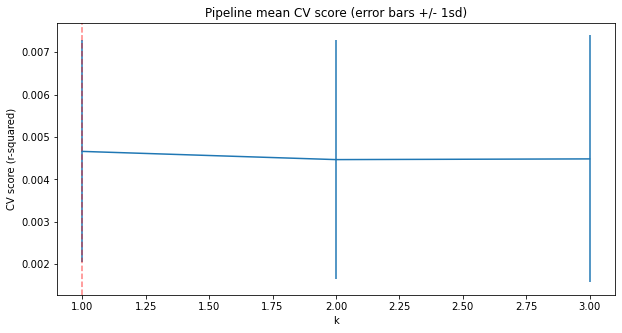

In [92]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [93]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()


In [94]:
#Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

Elo Difference    0.036048
dtype: float64

# Random Forest Model


In [95]:
#Code task 22#
#Define a pipeline comprising the steps:
#SimpleImputer() with a strategy of 'median'
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47, n_jobs=12)
)


In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# RF_pipe = make_pipeline(
#     SimpleImputer(strategy='median'),
#     StandardScaler(),
#     RandomForestClassifier(random_state=47, n_jobs=12)
# )

In [96]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [97]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([-0.25348865, -0.21963089, -0.26505929, -0.19918313, -0.23683035])

In [98]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)


(-0.23483846356842758, 0.02352729683692021)

In [99]:
# Hyperparameter search using GridSearchCV

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [ ]:
# # Hyperparameter search using GridSearchCV

# n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
# grid_params = {
#         'randomforestclassifier__n_estimators': n_est,
#         'standardscaler': [StandardScaler(), None],
#         'simpleimputer__strategy': ['mean', 'median']
# }

In [100]:
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [101]:
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(n_jobs=12,
                                                              random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [102]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 1000,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

In [103]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([-0.2421083 , -0.21776133, -0.25237818, -0.19721113, -0.22829094])

In [104]:
np.mean(rf_best_scores), np.std(rf_best_scores)


(-0.22754997514747144, 0.019210394943545598)

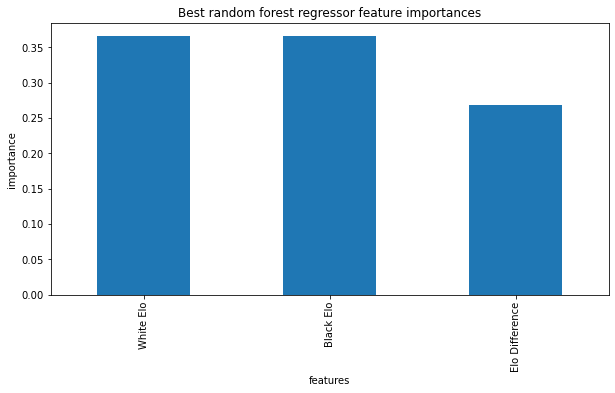

In [105]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

# Final Model Selection

Linear regression model performance

In [106]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [107]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(0.47487209480546966, 0.0008346534382720318)

In [108]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))


0.47669898366610897

Random forest regression model performance

In [109]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [110]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(0.48483207018848395, 0.003868701419440074)

In [111]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))


0.483818099534529

# Data quantity assessment


In [112]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

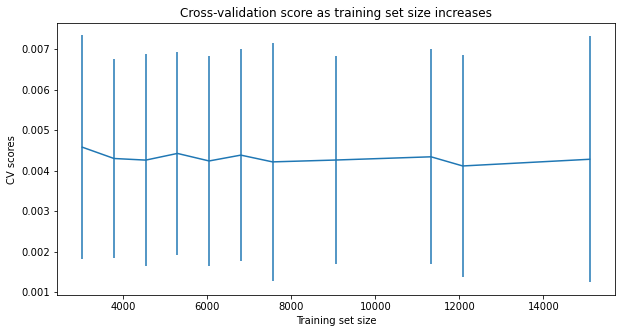

In [113]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');